In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp
from settings import colors

In [2]:
mplego.style.use_latex_style()
ccycle = mplego.colors.get_default_ccycle()

In [3]:
exp = 10
base_path = f"/storage/fits/neurocorr/exp{exp}"

In [4]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')

In [5]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [6]:
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [9]:
with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)

In [10]:
# Calculate correlations between max CDFs and percentiles
fa_corrs = np.zeros((len(results), dims.size))

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        fa_corrs[result_idx, dim_idx] = spearmanr(
            result['p_fa_lfi'][dim_idx],
            np.log(opt_fa_ffs[result_idx][dim_idx] / obs_ffs[result_idx][dim_idx]),
        ).correlation

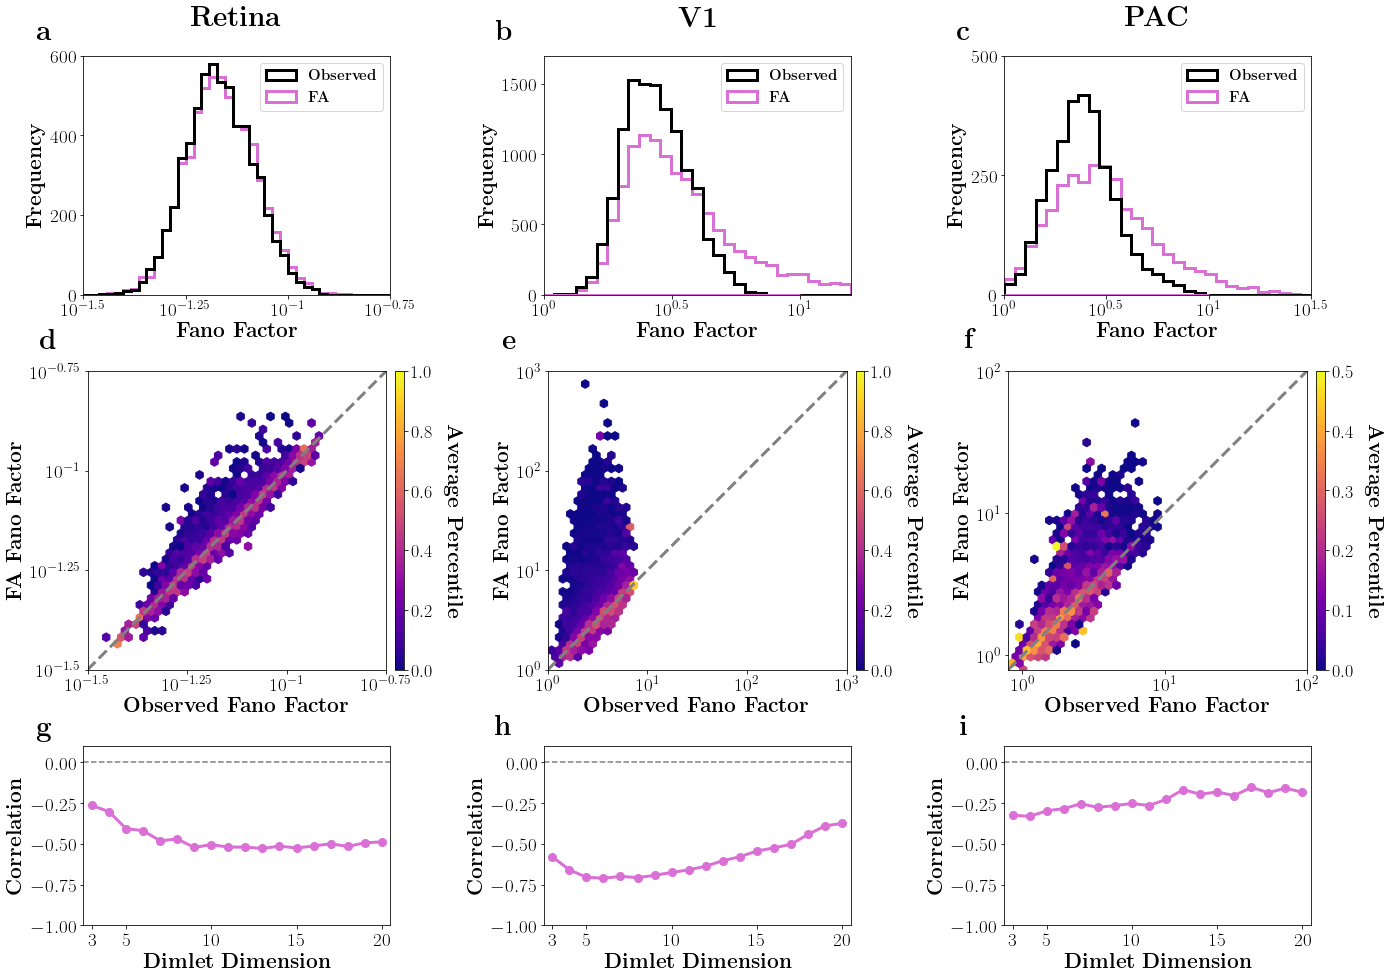

In [18]:
"""
Figure Settings
"""
figsize = (22, 16)
height_ratios = [0.8, 1, 0.6]
wspace = 0.5
hspace = 0.32

# Histogram settings
hist_lw = 3

# Layout settings
cb_spacing = 0.03
cb_width = 0.03
subplot_x = -0.13
subplot_y = 1.1

# Hexbin settings
gridsize = 40

# Scatter settings
markersize = 100
meanmarkersize = 500

# Font sizes
axis_label_size = 21
axis_tick_size = 19
cb_tick_size = 18
marginal_tick_size = 18
subplot_label_size = 28
title_size = 28
title_pad = 30

model_labels = mplego.labels.bold_text(['Observed', 'FA'])
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}
bins = [
    np.linspace(-1.5, -0.75, 40),
    np.linspace(0, 1.2, 30),
    np.linspace(0, 1.5, 30)
]

"""
Figure 6
"""
fig, axes = plt.subplots(
    3, 3,
    figsize=figsize,
    gridspec_kw={'height_ratios': height_ratios})
plt.subplots_adjust(wspace=wspace, hspace=hspace)

dim_idx = 0
norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=0.5)
]
extents = [
    (-1.5, -0.75, -1.5, -0.75),
    (0, 3, 0, 3),
    (-0.1, 2, -0.1, 2)
]


for idx, (result, norm, extent) in enumerate(zip(results, norms, extents)):
    # Calculate relevant quantities
    log_obs_ffs = np.log10(obs_ffs[idx][dim_idx])
    log_opt_fa_ffs = np.log10(opt_fa_ffs[idx][dim_idx])

    axes[0, idx].hist(
        [log_obs_ffs, log_opt_fa_ffs],
        histtype='step',
        color=[colors['observed'], colors['fa']],
        lw=hist_lw,
        bins=bins[idx])
    for key, label in label_dict.items():
        axes[0, idx].hist([], color=colors[key], label=label, histtype='step', lw=hist_lw)
    axes[0, idx].legend(
        loc='best',
        prop={'size': 15})
    axes[0, idx].set_xlabel(r'\textbf{Fano Factor}', fontsize=axis_label_size)
    axes[0, idx].set_ylabel(r'\textbf{Frequency}', fontsize=axis_label_size)
    
    # Hexbin comparing FFs to FA null model
    percentiles = result['p_fa_lfi'][dim_idx]
    axes[1, idx].hexbin(
        log_obs_ffs,
        log_opt_fa_ffs,
        C=percentiles,
        gridsize=gridsize,
        cmap='plasma',
        extent=extent,
        norm=norm)
    # Tighten hexbin plot
    mplego.scatter.tighten_scatter_plot(
        axes[1, idx],
        lim=extent[:2],
        color='gray',
        lw=3,
        linestyle='--')
    # Colorbar for hexbin
    cax = mplego.axes.append_marginal_axis(
        axes[1, idx],
        spacing=cb_spacing,
        width=cb_width)
    fig.colorbar(ScalarMappable(norm=norm, cmap='plasma'), cax=cax)
    cax.set_ylabel(
        r'\textbf{Average Percentile}',
        fontsize=axis_label_size,
        rotation=270,
        labelpad=30)
    cax.tick_params(labelsize=cb_tick_size)
    axes[1, idx].set_xlabel(r'\textbf{Observed Fano Factor}', fontsize=axis_label_size)
    axes[1, idx].set_ylabel(r'\textbf{FA Fano Factor}', fontsize=axis_label_size)

    # Fourth Row    
    axes[2, idx].plot(
        dims,
        fa_corrs[idx],
        color=colors['fa'],
        marker='o',
        lw=3,
        markersize=8,
        zorder=1000)
    axes[2, idx].axhline(0, color='gray', linestyle='--')

for ax in axes.ravel():
    ax.tick_params(labelsize=axis_tick_size)

# Top row settings
axes[0, 0].set_xlim([-1.5, -0.75])
axes[0, 0].set_xticks([-1.5, -1.25, -1, -0.75])
axes[0, 0].set_xticklabels([r'$10^{-1.5}$', r'$10^{-1.25}$', r'$10^{-1}$', r'$10^{-0.75}$'])
axes[0, 0].set_ylim([0, 600])
axes[0, 0].set_yticks([0, 200, 400, 600])

axes[0, 1].set_xlim([0, 1.2])
axes[0, 1].set_xticks([0, 0.5, 1.])
axes[0, 1].set_xticklabels([r'$10^0$', r'$10^{0.5}$', r'$10^1$'])
axes[0, 1].set_ylim([0, 1700])
axes[0, 1].set_yticks([0, 500, 1000, 1500])

axes[0, 2].set_xlim([0, 1.5])
axes[0, 2].set_xticks([0, 0.5, 1., 1.5])
axes[0, 2].set_xticklabels([r'$10^0$', r'$10^{0.5}$', r'$10^1$', r'$10^{1.5}$'])
axes[0, 2].set_ylim([0, 500])
axes[0, 2].set_yticks([0, 250, 500])

# Middle row settings
axes[1, 0].set_xticks([-1.5, -1.25, -1, -0.75])
axes[1, 0].set_xticklabels([r'$10^{-1.5}$', r'$10^{-1.25}$', r'$10^{-1}$', r'$10^{-0.75}$'])
axes[1, 0].set_yticks(axes[1, 0].get_xticks())
axes[1, 0].set_yticklabels(axes[1, 0].get_xticklabels())

axes[1, 1].set_xticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[1, 1].set_yticks(axes[1, 1].get_xticks())
axes[1, 1].set_yticklabels(axes[1, 1].get_xticklabels())

axes[1, 2].set_xticks([0, 1, 2])
axes[1, 2].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
axes[1, 2].set_yticks(axes[1, 2].get_xticks())
axes[1, 2].set_yticklabels(axes[1, 2].get_xticklabels())

# Bottom row settings
for ax in axes[-1]:
    ax.set_xlim([2.5, max(dims) + 0.5])
    ax.set_ylim([-1, 0.1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([-1, -0.75, -0.5, -0.25, 0])
    ax.set_xlabel(r'\textbf{Dimlet Dimension}', fontsize=axis_label_size)
    ax.set_ylabel(r'\textbf{Correlation}', fontsize=axis_label_size)

# Apply titles
axes[0, 0].set_title(r'\textbf{Retina}', fontsize=title_size, pad=title_pad)
axes[0, 1].set_title(r'\textbf{V1}', fontsize=title_size, pad=title_pad)
axes[0, 2].set_title(r'\textbf{PAC}', fontsize=title_size, pad=title_pad)

# Apply subplot labels
mplego.labels.apply_subplot_labels(
    axes.ravel(),
    bold=True,
    x=subplot_x,
    y=subplot_y,
    size=subplot_label_size)

plt.savefig('figure5.pdf', bbox_inches='tight')
plt.show()